In [93]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
# import seaborn as sns
import datetime
import pathlib
import io
import os
import re
import string
import time
import gensim.downloader as api
import tensorflow_datasets as tfds
# from PIL import image
from numpy import random
from sklearn.metrics import confusion_matrix, roc_curve
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Dense, Flatten, SimpleRNN, Conv1D, GRU, LSTM, BatchNormalization, Dropout, Input,                          Embedding, Bidirectional)
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy, TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorboard.plugins import projector

In [2]:
BATCH_SIZE = 64

## Data Preperation

In [3]:
train_ds, val_ds, test_ds = tfds.load('imdb_reviews', split=['train', 'test[:50%]', 'test[50%:]'], as_supervised=True)

In [4]:
train_ds

<PrefetchDataset shapes: ((), ()), types: (tf.string, tf.int64)>

In [5]:
for review, label in train_ds.take(2):
    print(review)
    print(label)

tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on t

In [6]:
def standardization(input_data):
    lowercase=tf.strings.lower(input_data)
    no_tag=tf.strings.regex_replace(lowercase,"<[^>]+>","")
    output=tf.strings.regex_replace(no_tag,"[%s]"%re.escape(string.punctuation),"")

    return output

In [7]:
standardization(tf.constant("This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."))

<tf.Tensor: shape=(), dtype=string, numpy=b'this was an absolutely terrible movie dont be lured in by christopher walken or michael ironside both are great actors but this must simply be their worst role in history even their great acting could not redeem this movies ridiculous storyline this movie is an early nineties us propaganda piece the most pathetic scenes were those when the columbian rebels were making their cases for revolutions maria conchita alonso appeared phony and her pseudolove affair with walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning i am disappointed that there are movies like this ruining actors like christopher walkens good name i could barely sit through it'>

In [8]:
VOCAB_SIZE = 10000
SEQUENCE_LENGTH = 250
EMBEDDING_DIM = 300

In [9]:
vectorize_layer=TextVectorization(
    standardize=standardization,
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=SEQUENCE_LENGTH
)

In [10]:
training_data=train_ds.map(lambda x,y:x)
vectorize_layer.adapt(training_data)

In [11]:
len(vectorize_layer.get_vocabulary())

10000

In [12]:
for review, label in train_ds.take(1):
    print(review)
    print(label)

tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


In [24]:
def vectorizer(review, label):  
    return vectorize_layer(review), label

In [25]:
train_dataset=train_ds.map(vectorizer)
val_dataset=val_ds.map(vectorizer)

In [26]:
vectorize_layer.get_vocabulary()[411]

'absolutely'

In [27]:
for review,label in train_dataset.take(1):
  print(review)
  print(label)

tf.Tensor(
[  10   13   33  411  384   17   89   26    1    8   32 1336 3518   40
  491    1  192   22   84  149   18   10  215  317   26   64  239  212
    8  484   54   64   84  111   95   21 5559   10   91  636  737   10
   17    7   33  393 9542  169 2442  406    2   87 1205  135   65  142
   52    2    1 7403   65  244   64 2829   16    1 2851    1    1 1419
 4965    3   39    1 1571   15 3518   13  156   18    4 1205  881 7864
    8    4   17   12   13 4033    5   98  145 1233   11  236  696   12
   48   22   91   37   10 7282  149   37 1336    1   49  397   11   95
 1148  840  140    9    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

In [28]:
train_dataset=train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset=val_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

## Modeling

### Simple RNN

In [29]:
inputs = np.random.random([32,10,8]).astype(np.float32)
simple_rnn = SimpleRNN(25)
output = simple_rnn(inputs)
print(output.shape)

(32, 25)


In [30]:
EMBEDDING_DIM = 64
model = tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH)),
    Embedding(VOCAB_SIZE, EMBEDDING_DIM),
    SimpleRNN(32),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 250, 64)           640000    
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 643,137
Trainable params: 643,137
Non-trainable params: 0
_________________________________________________________________


In [31]:
model.compile(loss=BinaryCrossentropy(),
              optimizer = Adam(1e-4),
              metrics=['accuracy'])

In [33]:
history = model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs = 10,
)

Epoch 1/10
391/391 [==============================] - 355s 907ms/step - loss: 0.6771 - accuracy: 0.5784 - val_loss: 0.6905 - val_accuracy: 0.5272
Epoch 2/10
391/391 [==============================] - 215s 548ms/step - loss: 0.6300 - accuracy: 0.6742 - val_loss: 0.5887 - val_accuracy: 0.7264
Epoch 3/10
391/391 [==============================] - 177s 452ms/step - loss: 0.5679 - accuracy: 0.7213 - val_loss: 0.6797 - val_accuracy: 0.5377
Epoch 4/10
391/391 [==============================] - 183s 467ms/step - loss: 0.4751 - accuracy: 0.8099 - val_loss: 0.4928 - val_accuracy: 0.7966
Epoch 5/10
391/391 [==============================] - 190s 485ms/step - loss: 0.3854 - accuracy: 0.8620 - val_loss: 0.4154 - val_accuracy: 0.8320
Epoch 6/10
391/391 [==============================] - 187s 480ms/step - loss: 0.3320 - accuracy: 0.8862 - val_loss: 0.3894 - val_accuracy: 0.8434
Epoch 7/10
391/391 [==============================] - 189s 484ms/step - loss: 0.2901 - accuracy: 0.9031 - val_loss: 0.4293 -

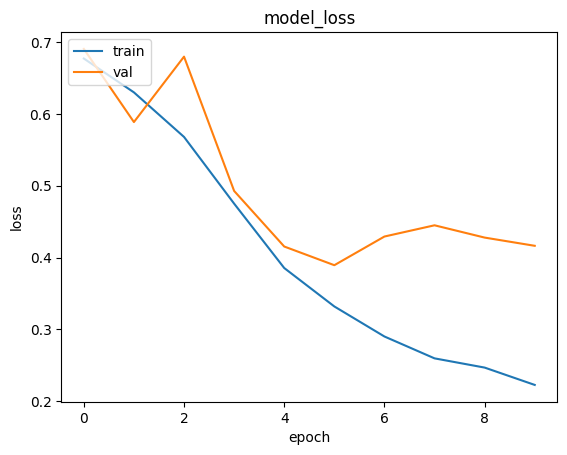

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

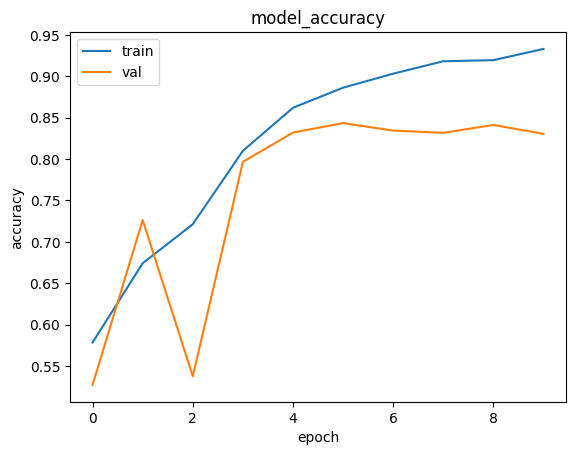

In [36]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Evaluation

In [37]:
test_dataset = test_ds.map(vectorizer)
test_dataset = test_dataset.batch(BATCH_SIZE)
model.evaluate(train_dataset)

391/391 [==============================] - 17s 42ms/step - loss: 0.2487 - accuracy: 0.9112


[0.24865004420280457, 0.9112399816513062]

### LSTM (Multilaayer & Bidirectional)

In [40]:
EMBEDDING_DIM = 64
model = tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH)),
    Embedding(VOCAB_SIZE, EMBEDDING_DIM),

    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),

    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 250, 64)           640000    
                                                                 
 bidirectional (Bidirectiona  (None, 250, 128)         66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [41]:
model.compile(loss=BinaryCrossentropy(),
              optimizer = Adam(1e-4),
              metrics=['accuracy'])

In [42]:
history = model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs = 10,
)

Epoch 1/10
391/391 [==============================] - 61s 125ms/step - loss: 0.6145 - accuracy: 0.6238 - val_loss: 0.4282 - val_accuracy: 0.8038
Epoch 2/10
391/391 [==============================] - 48s 122ms/step - loss: 0.3279 - accuracy: 0.8694 - val_loss: 0.3317 - val_accuracy: 0.8614
Epoch 3/10
391/391 [==============================] - 48s 124ms/step - loss: 0.2449 - accuracy: 0.9115 - val_loss: 0.3760 - val_accuracy: 0.8625
Epoch 4/10
391/391 [==============================] - 48s 123ms/step - loss: 0.2057 - accuracy: 0.9308 - val_loss: 0.4362 - val_accuracy: 0.8512
Epoch 5/10
391/391 [==============================] - 48s 122ms/step - loss: 0.1814 - accuracy: 0.9396 - val_loss: 0.4301 - val_accuracy: 0.8542
Epoch 6/10
391/391 [==============================] - 48s 122ms/step - loss: 0.1671 - accuracy: 0.9454 - val_loss: 0.4283 - val_accuracy: 0.8376
Epoch 7/10
391/391 [==============================] - 47s 121ms/step - loss: 0.1448 - accuracy: 0.9538 - val_loss: 0.4705 - val_ac

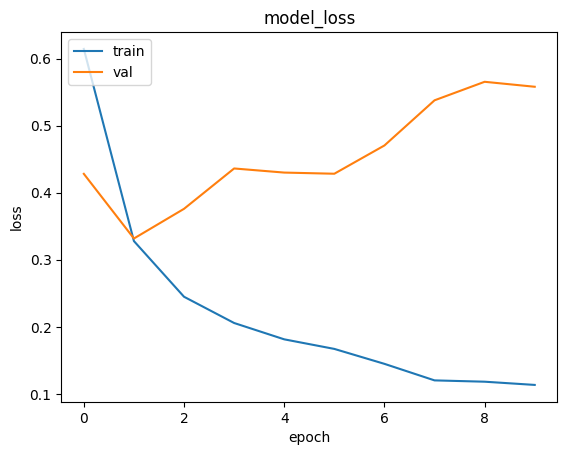

In [43]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

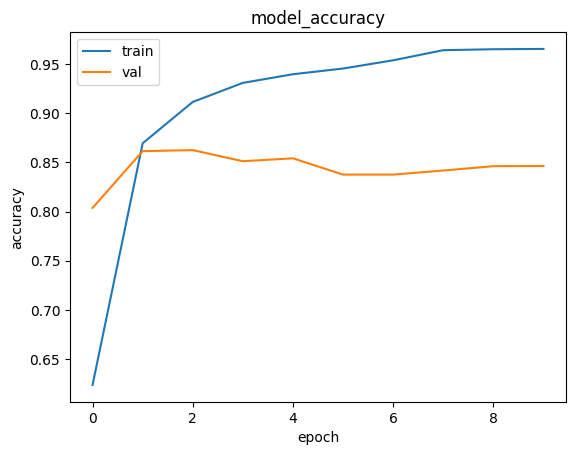

In [44]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Evaluation

In [45]:
test_dataset = test_ds.map(vectorizer)
test_dataset = test_dataset.batch(BATCH_SIZE)
model.evaluate(train_dataset)

391/391 [==============================] - 19s 47ms/step - loss: 0.0730 - accuracy: 0.9804


[0.07301641255617142, 0.9804400205612183]

### Conv1D

In [47]:
EMBEDDING_DIM = 300
mdoel = tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH)),
    Embedding(VOCAB_SIZE, EMBEDDING_DIM),

    Conv1D(32, 3, activation='relu'),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 250, 64)           640000    
                                                                 
 bidirectional (Bidirectiona  (None, 250, 128)         66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [48]:
model.compile(loss=BinaryCrossentropy(),
              optimizer = Adam(1e-4),
              metrics=['accuracy'])

In [49]:
history = model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs = 10,
)

Epoch 1/10
391/391 [==============================] - 53s 125ms/step - loss: 0.1135 - accuracy: 0.9641 - val_loss: 0.5728 - val_accuracy: 0.8445
Epoch 2/10
391/391 [==============================] - 48s 122ms/step - loss: 0.0913 - accuracy: 0.9736 - val_loss: 0.6020 - val_accuracy: 0.8439
Epoch 3/10
391/391 [==============================] - 51s 130ms/step - loss: 0.0797 - accuracy: 0.9781 - val_loss: 0.7100 - val_accuracy: 0.8350
Epoch 4/10
391/391 [==============================] - 49s 126ms/step - loss: 0.0735 - accuracy: 0.9806 - val_loss: 0.7153 - val_accuracy: 0.8410
Epoch 5/10
391/391 [==============================] - 48s 123ms/step - loss: 0.0717 - accuracy: 0.9805 - val_loss: 0.7488 - val_accuracy: 0.8398
Epoch 6/10
391/391 [==============================] - 47s 121ms/step - loss: 0.0774 - accuracy: 0.9774 - val_loss: 0.6977 - val_accuracy: 0.8429
Epoch 7/10
391/391 [==============================] - 49s 124ms/step - loss: 0.0702 - accuracy: 0.9800 - val_loss: 0.7045 - val_ac

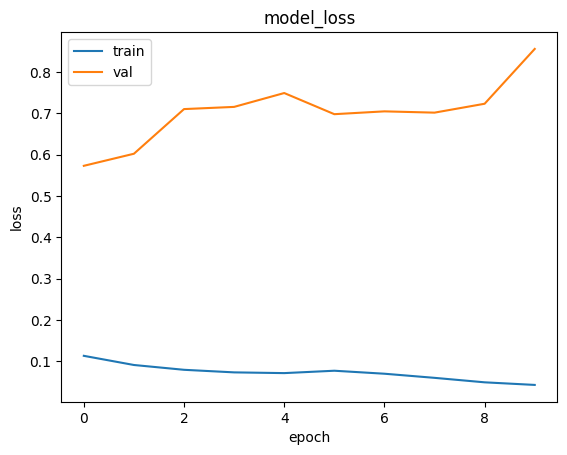

In [56]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

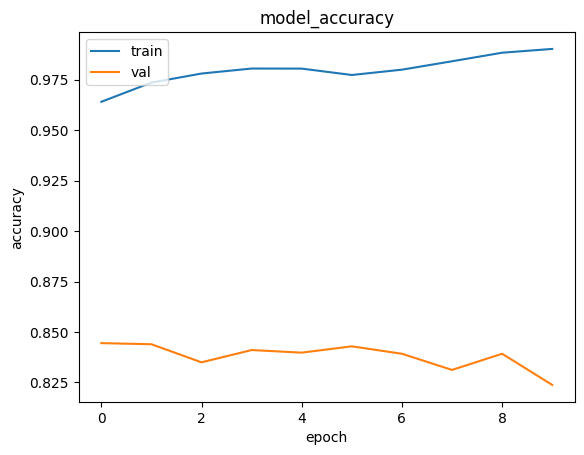

In [54]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Evaluation

In [55]:
test_dataset = test_ds.map(vectorizer)
test_dataset = test_dataset.batch(BATCH_SIZE)
model.evaluate(train_dataset)

391/391 [==============================] - 20s 49ms/step - loss: 0.1625 - accuracy: 0.9506


[0.1624894142150879, 0.9505599737167358]

### Pretrained Word2Vec(Gensim) 

In [62]:
word2vec = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [63]:
word2vec.vectors.shape

(3000000, 300)

In [64]:
len(word2vec['The'])

300

In [65]:
word2vec.most_similar('Man')

[('Woman', 0.6939345002174377),
 ('Boy', 0.5896925330162048),
 ('Girl', 0.584598958492279),
 ('Suspect', 0.5577560067176819),
 ('Couple', 0.5528685450553894),
 ('man', 0.5316051840782166),
 ('Robber', 0.5315312743186951),
 ('Teenager', 0.5161930322647095),
 ('depicts_Michelangelo_Creation', 0.5148172378540039),
 ('Policeman', 0.5136396884918213)]

In [66]:
pretrained_embeddings=[]

In [67]:
def first_caps(word):
    return word[0].upper+word[1:]

In [68]:
vectorize_layer.get_vocabulary()[2]

'the'

In [69]:
len(vectorize_layer.get_vocabulary())

10000

In [70]:
for i in range(len(vectorize_layer.get_vocabulary())):
  try:
    pretrained_embeddings.append(word2vec[vectorize_layer.get_vocabulary()[i]])
  except:
    print(vectorize_layer.get_vocabulary()[i])
    try:
      pretrained_embeddings.append(word2vec[first_caps(vectorize_layer.get_vocabulary()[i])])
      print('toupper')
    except:
      print('nosolution')
      pretrained_embeddings.append(random.normal(loc=0, scale=1, size=(EMBEDDING_DIM)))#reloaded_word_vectors[vectorize_layer.get_vocabulary()[i]])
  if i%1000==0:
    print('iis====================================',i)


nosolution
iis==================================== 0
[UNK]
nosolution
and
nosolution
a
nosolution
of
nosolution
to
nosolution
doesnt
nosolution
didnt
nosolution
isnt
nosolution
wasnt
nosolution
10
nosolution
80s
nosolution
20
nosolution
70s
nosolution
iis==================================== 1000
15
nosolution
12
nosolution
30
nosolution
humour
nosolution
100
nosolution
hasnt
nosolution
shouldnt
nosolution
90
nosolution
favourite
nosolution
theatre
nosolution
60s
nosolution
40
nosolution
lowbudget
nosolution
tarzan
nosolution
50
nosolution
90s
nosolution
1950s
nosolution
iis==================================== 2000
keaton
nosolution
welles
nosolution
50s
nosolution
1010
nosolution
11
nosolution
1970s
nosolution
overthetop
nosolution
sinatra
nosolution
columbo
nosolution
1980s
nosolution
25
nosolution
1930s
nosolution
14
nosolution
13
nosolution
bmovie
nosolution
aint
nosolution
pacino
nosolution
moviethe
nosolution
itthe
nosolution
writerdirector
nosolution
lugosi
nosolution
hitchcock


In [71]:
pretrained_embeddings_array=np.array(pretrained_embeddings)
print(pretrained_embeddings_array.shape)

(10000, 300)


In [72]:
pretrained_embeddings_array.shape

(10000, 300)

In [73]:
EMBEDDING_DIM=300
model=tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(
        VOCAB_SIZE,
        EMBEDDING_DIM,
        embeddings_initializer=tf.keras.initializers.Constant(pretrained_embeddings_array),
        trainable=True,
    ),

    Conv1D(32, 3, activation='relu',),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1,activation='sigmoid'),
])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 250, 300)          3000000   
                                                                 
 conv1d_1 (Conv1D)           (None, 248, 32)           28832     
                                                                 
 flatten_1 (Flatten)         (None, 7936)              0         
                                                                 
 dense_6 (Dense)             (None, 32)                253984    
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,282,849
Trainable params: 3,282,849
No

In [74]:
model.compile(loss=BinaryCrossentropy(),
              optimizer=Adam(1e-4),
              metrics=['accuracy'])

In [75]:
history=model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10
)

Epoch 1/10
391/391 [==============================] - 25s 39ms/step - loss: 0.6983 - accuracy: 0.5091 - val_loss: 0.6929 - val_accuracy: 0.5140
Epoch 2/10
391/391 [==============================] - 26s 67ms/step - loss: 0.6902 - accuracy: 0.5237 - val_loss: 0.6933 - val_accuracy: 0.5184
Epoch 3/10
391/391 [==============================] - 16s 40ms/step - loss: 0.6800 - accuracy: 0.5524 - val_loss: 0.6811 - val_accuracy: 0.5626
Epoch 4/10
391/391 [==============================] - 8s 20ms/step - loss: 0.6353 - accuracy: 0.6325 - val_loss: 0.5973 - val_accuracy: 0.6914
Epoch 5/10
391/391 [==============================] - 8s 21ms/step - loss: 0.4733 - accuracy: 0.7773 - val_loss: 0.4025 - val_accuracy: 0.8240
Epoch 6/10
391/391 [==============================] - 8s 21ms/step - loss: 0.3457 - accuracy: 0.8570 - val_loss: 0.3562 - val_accuracy: 0.8444
Epoch 7/10
391/391 [==============================] - 8s 21ms/step - loss: 0.2857 - accuracy: 0.8866 - val_loss: 0.3428 - val_accuracy: 0.8

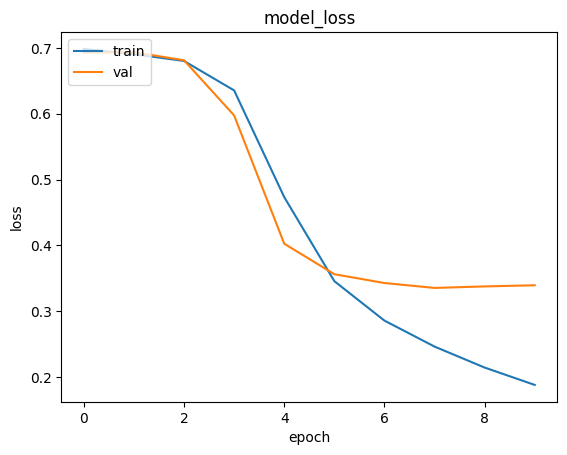

In [76]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

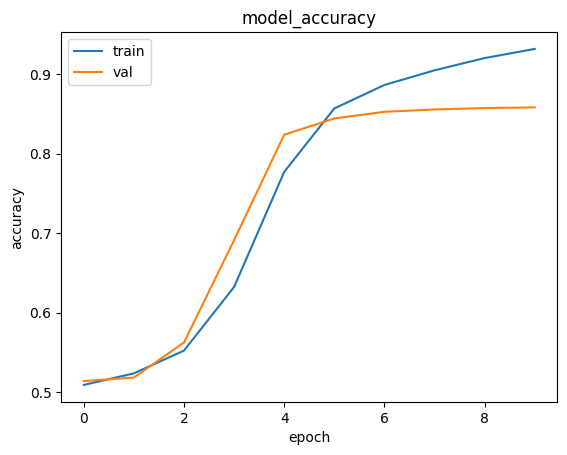

In [77]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Evaluation

In [78]:
test_dataset=test_ds.map(vectorizer)
test_dataset=test_dataset.batch(BATCH_SIZE)
model.evaluate(test_dataset)

196/196 [==============================] - 4s 16ms/step - loss: 0.3449 - accuracy: 0.8539


[0.3449142277240753, 0.8539199829101562]

## Testing

In [79]:
test_data=tf.data.Dataset.from_tensor_slices([["this movie looks very interesting, i love the fact that the actors do a great job in showing how people lived in the 18th century, which wasn't very good at all. But atleast this movie recreates this scenes! "],
                                              ["very good start, but movie started becoming interesting at some point and fortunately at some point it started becoming much more fun, though there was too much background noise, so in all i liked this movie "],])


In [80]:
def vectorizer_test(review):
    return vectorize_layer(review)
test_dataset=test_data.map(vectorizer_test)

In [81]:
model.predict(test_dataset)

array([[0.8671385 ],
       [0.76442736]], dtype=float32)

## Model with Vectorizer

In [82]:
inputs = Input(shape=(1,), dtype="string")
vectorized_inputs=vectorize_layer(inputs) 
outputs = model(vectorized_inputs) 
inference_ready_model = tf.keras.Model(inputs, outputs) 
inference_ready_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 250)              0         
 torization)                                                     
                                                                 
 sequential_4 (Sequential)   (None, 1)                 3282849   
                                                                 
Total params: 3,282,849
Trainable params: 3,282,849
Non-trainable params: 0
_________________________________________________________________


In [83]:
inference_ready_model.predict(["this movie looks very interesting, i love the fact that the actors do a great job in showing how people lived in the 18th century, which wasn't very good at all. But atleast this movie recreates this scenes! ",
                               "very good start, but movie started becoming interesting at some point and fortunately at some point it started becoming much more fun, though there was too much background noise, so in all i liked this movie "])

array([[0.8671385],
       [0.7644274]], dtype=float32)

## Visualize Embedding

In [84]:
EMBEDDING_DIM=300
model=tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(VOCAB_SIZE,EMBEDDING_DIM),

    Conv1D(32, 3, activation='relu',),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1,activation='sigmoid'),
])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 250, 300)          3000000   
                                                                 
 conv1d_2 (Conv1D)           (None, 248, 32)           28832     
                                                                 
 flatten_2 (Flatten)         (None, 7936)              0         
                                                                 
 dense_8 (Dense)             (None, 32)                253984    
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,282,849
Trainable params: 3,282,849
No

In [85]:
model.compile(loss=BinaryCrossentropy(),
              optimizer=Adam(1e-4),
              metrics=['accuracy'])

In [86]:
log_dir='logs/imdb/fit/'+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+'/'

In [87]:
tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir,histogram_freq=1)

In [88]:
history=model.fit(
    train_dataset.take(34),
    validation_data=val_dataset,
    epochs=1,
    callbacks=[tensorboard_callback])

34/34 [==============================] - 5s 119ms/step - loss: 0.6941 - accuracy: 0.4982 - val_loss: 0.6931 - val_accuracy: 0.5061


In [89]:
with open(os.path.join(log_dir,'metadata.tsv'),"w",encoding="utf-8") as f:
  for i in range(VOCAB_SIZE):
    f.write("{} {}\n".format(i,vectorize_layer.get_vocabulary()[i]))

In [90]:
embedding_weights=tf.Variable(model.layers[0].get_weights()[0])
print(embedding_weights.shape)

(10000, 300)


In [94]:
checkpoint=tf.train.Checkpoint(embedding=embedding_weights)
checkpoint.save(os.path.join(log_dir,"embedding.ckpt"))

config=projector.ProjectorConfig()
embedding=config.embeddings.add()

In [95]:
embedding.metadata_path='metadata.tsv'
projector.visualize_embeddings(log_dir,config)

In [96]:
%load_ext tensorboard

In [97]:
%tensorboard --logdir logs/imdb/fit/